# a)


128 128 (128, 64, 32, 1) (1, 32, 64, 128)


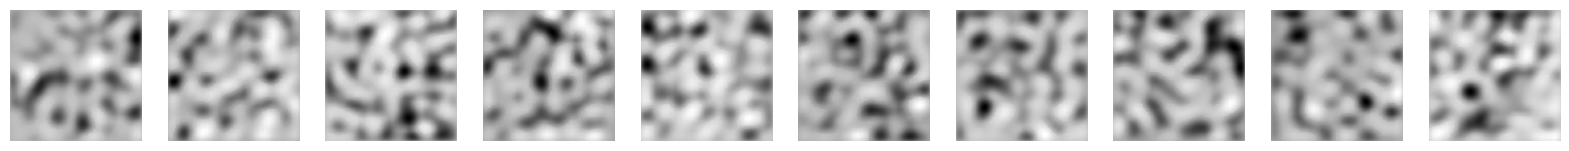

In [4]:
import torch
import matplotlib.pyplot as plt
from deep_generative_models.model_mashood import VAE
from config.paths import STORAGE

MODEL_PATH = STORAGE / "trained_model_VAE_MASHOOD_20241127_194150.pth"
model = VAE(input_dim=128, last_hidden_dim=128, encoder_channels=(1, 32, 64, 128), decoder_channels=(128, 64, 32, 1), device=torch.device("cpu"))
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))
model.eval()

z_samples = torch.randn(10, 128)

generated_images = model.decode(z_samples)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(generated_images):
    axes[i].imshow(img.view(128, 128).detach().numpy(), cmap='gray')
    axes[i].axis('off')
plt.show()


The images display plausible images. The only issue is that they are quite blurry. This could be omitted by utilizing a beta VAE or different loss as discussed here: https://ai.stackexchange.com/questions/37272/what-is-an-appropriate-size-for-a-latent-space-of-variational-autoencoders-and

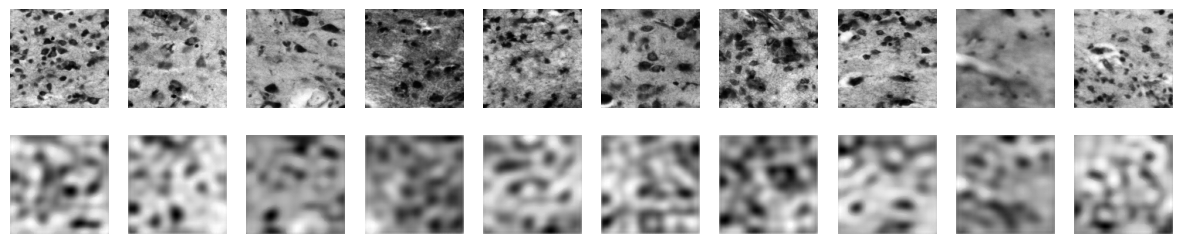

In [5]:
# Load the test data
from config.paths import CELL_DATA
from deep_generative_models.dataset import create_dataloader


test_loader = create_dataloader(CELL_DATA, ["B20"], tile_size=128, batch_size=10, tiles_per_epoch=10, num_workers=0)

# Get a batch of test images
test_images = next(iter(test_loader))

# Reconstruct the images using the VAE
with torch.no_grad():
    reconstructed_images, _, _ = model(test_images)

# Plot the original and reconstructed images
def plot_reconstructed_images(original, reconstructed):
    original = original.view(-1, 128, 128).cpu().numpy()
    reconstructed = reconstructed.view(-1, 128, 128).cpu().numpy()
    fig, axes = plt.subplots(2, len(original), figsize=(15, 3))
    for i in range(len(original)):
        axes[0, i].imshow(original[i], cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i], cmap="gray")
        axes[1, i].axis("off")
    plt.show()

plot_reconstructed_images(test_images, reconstructed_images)

# b)

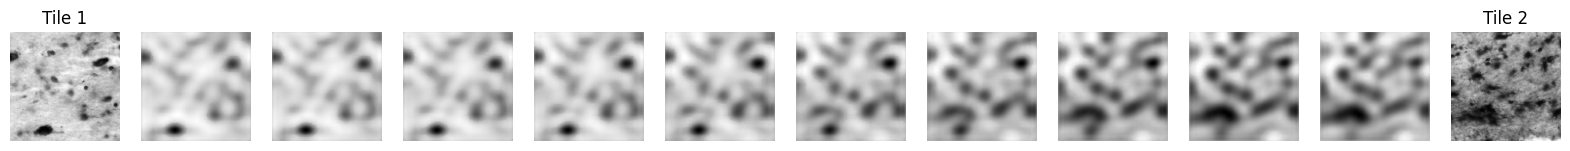

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the test data
test_loader = create_dataloader(CELL_DATA, ["B20"], tile_size=128, batch_size=1, tiles_per_epoch=3000, num_workers=0)

tile1, tile2 = next(iter(test_loader)), next(iter(test_loader))

_, mean1 = model.encode(tile1)
_, mean2 = model.encode(tile2)

# Define k interpolation steps
k = 10
interpolated_z = [mean1 + (mean2 - mean1) * i / (k - 1) for i in range(k)]

# Decode each interpolated vector
interpolated_images = [model.decode(z) for z in interpolated_z]

# Plot original and interpolated images
fig, axes = plt.subplots(1, k + 2, figsize=(20, 2))
axes[0].imshow(tile1.view(128, 128).detach().numpy(), cmap='gray')
axes[0].set_title('Tile 1')
axes[0].axis('off')

for i, img in enumerate(interpolated_images):
    axes[i + 1].imshow(img.view(128, 128).detach().numpy(), cmap='gray')
    axes[i + 1].axis('off')

axes[-1].imshow(tile2.view(128, 128).detach().numpy(), cmap='gray')
axes[-1].set_title('Tile 2')
axes[-1].axis('off')

plt.show()


# C)

/var/folders/4g/91bm8hl51ld9v8c8tg6_lrqw0000gn/T/ipykernel_41105/2692973927.py:21: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=z_pca[:, 0], y=z_pca[:, 1], palette="viridis")


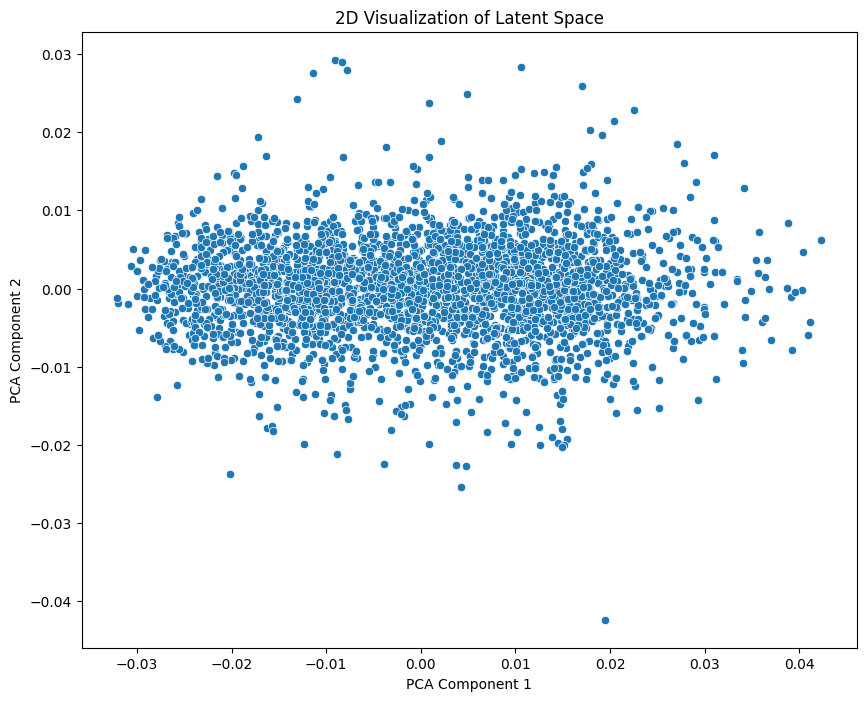

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import torch

# Sample ~3,000 tiles
tiles = []
for i, tile in enumerate(test_loader):
    if i >= 3000:
        break
    tiles.append(tile)
tiles = torch.cat(tiles)

var, mean = model.encode(tiles)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
z_pca = pca.fit_transform(mean.detach().numpy())

# Plot the reduced latent space
plt.figure(figsize=(10, 8))
sns.scatterplot(x=z_pca[:, 0], y=z_pca[:, 1], palette="viridis")
plt.title("2D Visualization of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


The plot shows a 2D representation of encoded brain tiles after reducing their dimensions using PCA. Most of the data points are tightly clustered around the center, forming a smooth and continuous distribution. This indicates that the Variational Autoencoder (VAE) has learned a compact and consistent representation of the input tiles. There are no clear clusters or gaps, suggesting the tiles share similar features and don't have strong variations or subgroups. Overall, the latent space appears smooth and interpretable, which means the encoder is functioning effectively.